# Project: Epidemics in the air

## Introduction

In the project work, your task is to implement a Susceptible-Infected (SI) disease spreading model and run it on top of a temporal network from air transport data, containing information on the departure and arrival times of flights. You will study the dynamics of spreading and how it depends on where the process starts as well as the infectivity of the disease, and use static-network centrality measures to understand the roles that specific nodes play.

You may use this notebook to get started. However, **using the notebook is fully optional.** If using the notebook, you only need to fill in the required functions. Some of the functions do **not** need modifications. You may start your solution after the subtitle "**Begin of the Exercise**" down below. 

In addition to returning a short report of your results (including the visualizations), return also your commented Python code or notebook (all code related to the project as a single **zip** file). **Always label the axes in your figures!** When reporting your results, remember to answer all questions asked in the exercise sheet. Please note that this notebook contains only the programming tasks of the project, not the questions about interpreting the results. Therefore, before writing your report, consult the exercise sheet available in MyCourses.

## Model specifications

In the SI model, each node is either Susceptible (S) or Infected (I). When an Infected node is in contact with a Susceptible node, the Susceptible node may become infected with some probability _p ∈_ [0, 1], reflecting the infectivity of the disease. Infected nodes remain Infected forever.

In our model that mimics the spreading of disease through the air transport network, nodes are airports and time-stamped connections are flights between them. Initially, only one airport node (called the seed node) is set to the Infected state, while all other airports are Susceptible. Now, following the SI process, a flight from an Infected source airport infects its Susceptible destination airport with probability _p ∈_ [0, 1]. Note that a flight can carry the infection only if its source airport is infected at the time of the flight’s departure! Infected airports remain infected for the rest of the simulation.

## Data description

The data that are used in the project are available at `/coursedata/project`. You can also download the data from the course MyCourses page as a `.zip` file. 

The flight data that you will use to perform your simulation are located in the file `events_US_air_traffic_GMT.txt`, where each row contains the following fields:

<pre>
1st column -> Source [0-278]
2nd column -> Destination [0-278]
3rd column -> Start Time (GMT) [seconds after Unix epoch time]
4th column -> End Time (GMT)
5th column -> Duration [Same as (EndTime-StartTime)]
</pre>

The aggregated weighted network `aggregated_US_air_traffic_network_undir.edg` is constructed based on the event data, so that the weight of each link corresponds to the number of flights between the nodes. This network is static and undirected. Additionally, you can find the information about the airports in file `US_airport_id_info.csv`. `US_air_bg.png` is an image of the USA map used as a background image in some visualizations.

In [1]:
import networkx as nx
import numpy as np
from numpy import random
import pandas as pd
import pickle
import time
import os
from collections import Counter
from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import rc
from tqdm import tqdm
rc.usetex = True
from matplotlib.animation import FuncAnimation
import scipy.stats
from pathlib import Path

# Data

Let us load the data from the right folder and specify paths of files used in the project. If you run this notebook on your own computer, please specify the right folder.

In [2]:
# Select data directory
import os

if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    course_data_dir = 'data'

assert Path(course_data_dir).exists()

event_file_path = os.path.join(course_data_dir, 'events_US_air_traffic_GMT.txt')
network_file_path = os.path.join(course_data_dir, 'aggregated_US_air_traffic_network_undir.edg')
airport_info_file_path = os.path.join(course_data_dir, 'US_airport_id_info.csv')
background_image_file_path = os.path.join(course_data_dir, 'US_air_bg.png')

print('The data directory is {path}'.format(path=course_data_dir))
print('The event file is at {path}'.format(path=event_file_path))
print('The aggregated network file is at {path}'.format(path=network_file_path))
print('The airport info file is at {path}'.format(path=airport_info_file_path))
print('The visualization background image is at {path}'.format(path=background_image_file_path))

The data directory is data
The event file is at data/events_US_air_traffic_GMT.txt
The aggregated network file is at data/aggregated_US_air_traffic_network_undir.edg
The airport info file is at data/US_airport_id_info.csv
The visualization background image is at data/US_air_bg.png


## Visualization tools

The following visualization tools are provided to help you. There is no need to modify these parts.

The frunction `plot_prevalence` is used in multiple tasks from Task 2 onwards and `plot_scatters_in_subplots` from Task 4 onwards. The function `plot_network_USA` is used in Task 6. 

As an extra visualization, you can find a function called `visualize_si` which animates the air transport using `matplotlib`. The animations use the background image `US_air_bg.png`, the airport id-info file `US_airport_id_info.csv` and the events file `events_US_air_traffic_GMT.txt`, all of which are available at `/coursedata/project`. Note that this visualization is not needed for completion of the tasks, it’s just offered for your benefit.

In [3]:
def plot_prevalence(prevalence_data, time_steps, colors, labels, savefig=False, savepath=''):
    """
    Plots the prevalence of the disease (proportion of infected
    nodes) as a function of time (before each time step).
    Task: 2 
       
    Parameters:
    -----------
    prevalence_data : np.array
        the data to be plotted. Each row of prevalence_data is
        plotted as a separate plot. Number of columns should
        match the length of time_steps
    time_steps : np.array
        time steps used to calculate the prevalence. prevalence_data[N][i]
        should contain the proportion of nodes infected before time_steps[i]
        (in condition N)
    colors : list
        colors of the lines to be plotted. len(colors) should match the
        number of rows in prevalence_data
    labels : list
        labels of the lines to be plotted. len(labels) should match the
        number of rows in prevalence_data
    savefig : bln
        should the created figure be saved? Default False
    savepath : str
        path to which to save the created figure, if savefig == True
        
    Returns:
    --------
    fig : plt.figure
        The figure object containing the prevalence visualization
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    time_steps = time_steps - time_steps[0]  # origin shift: all times are now expressed as "after time_steps[0]"

    for prevalence, color, label in zip(prevalence_data, colors, labels):
        ax.plot(time_steps, prevalence, color=color, label=label)

    ax.legend(loc="best")
    ax.set_xlabel("Time in seconds after first event.")
    ax.grid()
    ax.set_ylabel("Prevalence of the disease")
    if savefig:
        fig.savefig(savepath)
    return fig

In [4]:
def plot_scatters_in_subplots(x_vals, y_vals, labels, n_columns=2, y_label='Infection time', x_labels=[], savefig=False,
                              savepath=''):
    """
    Creates a set of scatter plots, each of them located in
    a subplot of its own.
    Task: 4

    Parameters:
    -----------
    x_vals : list
        x values of the scatter plots (e.g. values of network properties to be plotted); x_vals[i]
        should be a list of x values of type i for all nodes
    y_vals: iterable
        y values of the scatter plots (e.g. median infection times); y_vals will be
        separately plotted against all elements of x_vals
    labels : list
        labels of the scatter points to be plotted. len(labels) should match the
        number of elements in x_vals.
    n_columns : int
        how many columns should the final figure contain, i.e. how many
        subplots there should be at each row
    x_labels : list
        labels of the x axes for each subplot (given as strings); 
        if given, len(x_labels) should match the number of elements
        in x_vals.
    y_label : str
        label of the y axis
    savefig : bln
        should the created figure be saved? Default False
    savepath : str
        path to which to save the created figure, if savefig == True
        
    Returns:
    --------
    fig : plt.figure
        The figure object containing the scatterplots
    """
    fig = plt.figure()

    n_subplots = len(x_vals)
    n_rows = int(np.ceil(n_subplots / np.float64(n_columns)))

    if len(x_labels) == 0:
        x_labels = labels

    for i, (x_val, label, x_label) in enumerate(zip(x_vals, labels, x_labels)):
        ax = fig.add_subplot(n_rows, n_columns, i + 1)
        ax.scatter(x_val, y_vals, label=label, alpha=0.2)
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.legend(loc="best")
    fig.tight_layout()
    if savefig:
        fig.savefig(savepath)
    return fig

In [5]:
def plot_network_usa(net, xycoords, background_image_file_path, edges=None, linewidths=None):
    """
    Plots the network on top of the USA map.
    This code makes use of the file US_air_bg.png available at /coursedata.
    If you want to use this function outside of Jupyterhub, the file
    should be located in the same directory where you run the code.
    Task: 6

    Parameters
    ----------
    net : nx.Graph()
        the network to be plotted
    xycoords : dict
        dictionary of node_ids as keys and coordinates (x,y) as values,
        contains the coordinates of network nodes
    background_image_file_path: str
        path of the background image used in the visualization (string); 
        in this project, the path of US_air_bg.png
    edges : list 
        a list of node index tuples (node_i,node_j), the selection of 
        network edges to be plotted. Default None; in this case, all network edges are plotted.
    linewidths : list
        a list of widths of edges (for details, see nx.draw_networkx documentation)
        len(linewidths) should match len(edges) and linewidths should be given
        in the same order as edges. Default None, in this case, all edges
        are plotted with width one.
        
    Returns
    -------
    fig : plt.figure
        the figure object containing the visualization
    ax : plt.axis
        the related axis object
    """

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 0.9])
    img = plt.imread(background_image_file_path)
    axis_extent = (-6674391.856090588, 4922626.076444283,
                   -2028869.260519173, 4658558.416671531)
    ax.imshow(img, extent=axis_extent)
    ax.set_xlim((axis_extent[0], axis_extent[1]))
    ax.set_ylim((axis_extent[2], axis_extent[3]))
    ax.set_axis_off()
    nx.draw_networkx_nodes(net,
                           pos=xycoords,
                           node_color='k',
                           node_size=5,
                           alpha=0.2)
    if edges is None:
        edges = net.edges()

    if linewidths is None:
        linewidths = np.ones(len(edges))

    for edge, lw in zip(edges, linewidths):
        nx.draw_networkx_edges(
            net,
            pos=xycoords,
            edge_color='r',
            width=lw,
            edgelist=[edge],
            alpha=lw,
        )
    return fig, ax

In [6]:
class SI_AnimHelper(object):
    """
    A class used for creating animated visualizations of the epidemic. 
    For a function making use of this class, see visualize_si below.
    Task: ?

    Attributes
    ----------
    ed : np.array
        event data; each row corresponds to a flight and columns contain
        (in this order) the source, destination, start time, end time, and
        duration of each flight
    infection_times : numpy array
        infection times of the nodes (airports)
    xcoords : np.array
        x coordinates of network nodes (airports)
    ycoords : np.array
        y coordinates of network nodes (airports)
    fig : plt.figure
        a figure object for drawing the network
    ax : plt.axes
        a axes object for drawing the network
    axis_extend : set
        extend of the x and y axis
    img : matplotlib.image.AxesImage
        the image object containing the visualization
    time_text : matplotlib.text.Text
        the text object containing the text telling the current time point
    scat_planes : matplotlib.collections.PathCollection
        a scatter plot of the location of planes
    n : int
        the number of nodes (airports)
    airport_colors : np.array
        colors of nodes (airports)
    scat_airports : matplotlib.collections.PathCollection
        a scatter plot of the location of nodes (airports)
        
    Methods
    -------
    draw(frame_time)
        draws the situation of epidemic spreading at the given moment
        (that is, updates the attributes to correspond to the situation
        at the given moment)
    draw_anim(frame_time)
        calls draw and returns some of the updated attributes
    init()
        returns some attributes without updating
    """

    def __init__(self, infection_times, event_file_path, airport_info_file_path, background_image_file_path):
        """
        Parameters
        ----------
        infection_times : np.array
            infection times of nodes (airports)
        event_file_path : str
            path to the event information file
        airport_info_file_path : str
            path to the airport information file
        background_image_file_path: str
            path of the background image used in the visualization (string); 
            in this project, the path of US_air_bg.png
        """
        if not os.path.exists(event_file_path):
            raise IOError("File " + event_file_path + "could not be found")

        self.ed = np.genfromtxt(
            event_file_path,
            delimiter=' ',
            dtype=None,
            names=True,
            encoding=None
        )

        self.infection_times = infection_times

        if not os.path.exists(airport_info_file_path):
            raise IOError("File " + event_file_path + "could not be found")

        id_data = np.genfromtxt(
            airport_info_file_path,
            delimiter=',',
            dtype=None,
            names=True,
            encoding=None
        )
        self.xcoords = id_data['xcoordviz']
        self.ycoords = id_data['ycoordviz']
        self.fig = plt.figure(figsize=(10, 10))
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        img = plt.imread(background_image_file_path)
        self.axis_extent = (-6674391.856090588, 4922626.076444283,
                            -2028869.260519173, 4658558.416671531)
        self.img = self.ax.imshow(img, extent=self.axis_extent)
        self.ax.set_xlim((self.axis_extent[0], self.axis_extent[1]))
        self.ax.set_ylim((self.axis_extent[2], self.axis_extent[3]))
        self.ax.set_axis_off()
        self.time_text = self.ax.text(
            0.1, 0.1, "", transform=self.ax.transAxes)
        self.scat_planes = self.ax.scatter([], [], s=0.2, color="k")

        self.n = len(self.xcoords)
        self.airport_colors = np.array(
            [[0, 1, 0] for i in range(self.n)], dtype=float)
        self.scat_airports = self.ax.scatter(
            self.xcoords, self.ycoords, c=self.airport_colors, s=5, alpha=0.2)

    def draw(self, frame_time):
        """
        Draws the current situation of the epidemic spreading.

        Parameters
        ----------
        frame_time : int
            the current time in seconds
            (should lie somewhere between 1229231100 and 1230128400)
        """
        time_str = time.asctime(time.gmtime(frame_time))
        self.time_text.set_text(time_str)
        # this should be improved
        unfinished_events = (self.ed['EndTime'] > frame_time)
        started_events = (self.ed['StartTime'] < frame_time)

        # oge = 'on going events'
        oge = self.ed[started_events * unfinished_events]
        fracs_passed = (float(frame_time) - oge['StartTime']) / oge['Duration']
        ongoing_xcoords = ((1 - fracs_passed) * self.xcoords[oge['Source']]
                           + fracs_passed * self.xcoords[oge['Destination']])
        ongoing_ycoords = ((1 - fracs_passed) * self.ycoords[oge['Source']]
                           + fracs_passed * self.ycoords[oge['Destination']])
        self.scat_planes.set_offsets(
            np.array([ongoing_xcoords, ongoing_ycoords]).T)
        self.event_durations = self.ed['Duration']

        infected = (self.infection_times < frame_time)

        self.airport_colors[infected] = (1, 0, 0)  # red
        self.airport_colors[~infected] = (0, 1, 1)  # green
        self.scat_airports = self.ax.scatter(
            self.xcoords, self.ycoords, c=self.airport_colors, s=20, alpha=0.5)

    def draw_anim(self, frame_time):
        """
        Draws the epidemic situation at a given time and returns some attributes.
        
        Parameters
        ----------
        frame_time : int
            the current time in seconds
            (should lie somewhere between 1229231100 and 1230128400)
            
        Returns
        -------
        time_text : matplotlib.text.Text
            the text object containing the text telling the current time point
        scat_planes : matplotlib.collections.PathCollection
            a scatter plot of the location of planes
        scat_airports : matplotlib.collections.PathCollection
            a scatter plot of the location of nodes (airports)
        """
        self.draw(frame_time)
        return self.time_text, self.scat_planes, self.scat_airports

    def init(self):
        """
        Returns some attributes without updating
        
        Parameters
        ----------
        None
        
        Returns
        -------
        time_text : matplotlib.text.Text
            the text object containing the text telling the current time point
        scat_planes : matplotlib.collections.PathCollection
            a scatter plot of the location of planes
        scat_airports : matplotlib.collections.PathCollection
            a scatter plot of the location of nodes (airports)
        """
        return self.time_text, self.scat_planes, self.scat_airports

In [7]:
def visualize_si(infection_times,
                 event_file_path,
                 airport_info_file_path,
                 background_image_file_path,
                 viz_start_time=1229231100,
                 viz_end_time=1230128400,
                 tot_viz_time_in_seconds=60,
                 fps=10,
                 save_fname=None,
                 writer='ffmpeg'):
    """
    Animates the infection process as a function of time. If you want to show the animation in a Jupyter notebook,
    add the line
    %matplotlib notebook
    to your notebook before calling the function. Without this line, the animation can still be saved but is not
    shown.

    Parameters
    ----------
    infection_times : np array
        infection times of the nodes (airports)
    event_file_path : str
        path to the event information file
    airport_info_file_path : str
        path to the airport information file
    background_image_file_path: str
        path of the background image used in the visualization (string); 
        in this project, the path of US_air_bg.png
    viz_start_time : int
        start time in seconds after epoch. Default
        1229231100 corresponds to the beginning of the 
        simulation
    viz_end_time : int
        end_time in seconds after epoch. Default
        1230128400 corresponds to the end of the
        simulation
    tot_viz_time_in_seconds : int
        length of the animation for the viewer in seconds. 
        Default 60
    fps : int
        frames per second (use low values on slow computers).
        Default 10
    save_fname : str
        path to which to save the animation. Default None, in
        which case the animation is shown instead of saving.
    writer : str
        name of the matplitlib.animation Writer class for saving
        the animation. Default 'ffmpeg'
    """
    times = np.linspace(
        viz_start_time, viz_end_time, fps * tot_viz_time_in_seconds + 1)
    siah = SI_AnimHelper(infection_times, event_file_path, airport_info_file_path, background_image_file_path)
    ani = FuncAnimation(
        siah.fig, siah.draw_anim, init_func=siah.init, frames=times,
        interval=1000 / fps, blit=True
    )  # This is matplotlib.animation.FuncAnimation; see the Matplotlib documentation for details
    if save_fname is not None:
        print("Saving the animation can take quite a while.")

        print("Be patient...")

        ani.save(save_fname, writer=writer, codec='mpeg4')
    else:
        return ani

## Begin of the Exercise

### Task 1: Basic implementation

Implement the SI model using the temporal air traffic data in `events_US_air_traffic_GMT.txt`. Use the provided visualization module to check that your implementation works reasonably. Assume first that _p_ = 1, i.e., the disease is always transmitted.

If Salt Lake City (node-id=27) is infected at the beginning of the data set, at which time
does Anchorage (ANC, node-id=41) become infected?

_Hint:_ The time point should fall within the range `1229283000-1229284000`.

In [8]:
def get_net_and_id_data(network_file_path, airport_info_file_path):
    """
    Reads the network and airport information.

    Parameters
    ----------
    network_file_path : str
            path of the network file
    airport_info_file_path : str
            path of the airport info csv file

    Returns
    -------
    net : nx.Graph
            the weighted network read from the file
    id_data : pd.DataFrame
            information about airport id's, symbols, names, and cities
    """

    # Implement a function for reading the network and airport info

    # Ensure that your network nodes are integers (not e.g. strings) since many parts of the project are easier to implement
    # this way. When creating the network, you can specify the datatype of nodes with the nodetype parameter.
    net = nx.read_edgelist(network_file_path, nodetype=int, data=(("weight", float),))

    # Make use of read_csv from pandas for reading the airport info.
    id_data = pd.read_csv(airport_info_file_path)
    return net, id_data

In [9]:
# df_events
df_events = pd.read_csv(event_file_path, sep=" ")
df_events["StartTimeUnix"] = pd.to_datetime(df_events["StartTime"], unit="s")
df_events["EndTimeUnix"] = pd.to_datetime(df_events["StartTime"], unit="s")
df_events["DurationMins"] = df_events["Duration"] / 60
df_events = df_events.sort_values(by=["StartTime"])
df_events

,Source,Destination,StartTime,EndTime,Duration,StartTimeUnix,EndTimeUnix,DurationMins
16150,27,49,1229231100,1229246760,15660,2008-12-14 05:05:00,2008-12-14 05:05:00,261.0
16997,30,2,1229233200,1229245980,12780,2008-12-14 05:40:00,2008-12-14 05:40:00,213.0
14055,251,20,1229235000,1229246340,11340,2008-12-14 06:10:00,2008-12-14 06:10:00,189.0
9181,16,4,1229235300,1229250240,14940,2008-12-14 06:15:00,2008-12-14 06:15:00,249.0
9332,16,7,1229235300,1229245500,10200,2008-12-14 06:15:00,2008-12-14 06:15:00,170.0
...,...,...,...,...,...,...,...,...
170670,246,24,1230104700,1230125640,20940,2008-12-24 07:45:00,2008-12-24 07:45:00,349.0
168992,55,23,1230105000,1230124740,19740,2008-12-24 07:50:00,2008-12-24 07:50:00,329.0
168893,55,24,1230105300,1230127200,21900,2008-12-24 07:55:00,2008-12-24 07:55:00,365.0
174360,56,32,1230105420,1230123060,17640,2008-12-24 07:57:00,2008-12-24 07:57:00,294.0


In [10]:
df_airports = pd.read_csv(airport_info_file_path)
df_airports

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325
...,...,...,...,...,...,...,...,...
274,274,RDD,Redding Muni,Redding,40.509000,-122.293389,-1.976890e+06,334403.078441
275,275,SUN,Friedman Mem,Hailey,43.504444,-114.296194,-1.261565e+06,515731.793677
276,276,TWF,Magic Valley Regional Airport,Twin Falls,42.481803,-114.487733,-1.296508e+06,406881.420680
277,277,RHI,Rhinelander Oneida County Airport,Rhinelander,45.631200,-89.467500,7.102613e+05,678171.825235


In [11]:
def simulate_si(
        infection_prob,
        event_file_path,
        airport_info_file_path,
        seed=None,
        immunized_nodes=[],
        return_trans_nodes=False,
):
    """
    General function for simulating the SI dynamics.

    Parameters
    ----------
    infection_prob : float
        the probability of infection per flight
    event_file_path : str
        path of the event file
    airport_info_file_path : str
        path of the airport info file
    seed : int
        the seed node index. Default None, in which case the seed
        node is selected as random
    immunized_nodes : list
        indexes of nodes that have been immunized (used in task 5).
        Default [], in which case no nodes are immunized
    return_trans_nodes : bool
        if True, the function returns for for each node i the
        index of node j, from which the infection arrived to i. This
        parameter is used in task 6. Default False

    Returns:
    --------
    infection_times : iterable (list or np.array)
        time when each of the nodes gets infected, infection time of
        non-infected nodes is Inf
    seed : int
        index of the seed node used
    trans_nodes : list or np.array
        the origin of infection (i.e. the source of the infection-carrying
        flight) for each node. For example, if node i gets infected by a
        flight arriving from node j, trans_nodes[i] = j. For a node k that
        never gets infected, trans_nodes[k] = -1. This output is used in
        task 6. Only returned if return_trans_nodes == True

    """

    # pd.read_csv is handy for reading the event and airport data.
    df_events = pd.read_csv(event_file_path, sep=" ")
    df_airports = pd.read_csv(airport_info_file_path)

    # Default seed is None, in which case the seed node is selected as random
    if seed is None:
        seed = random.choice(df_airports["id"])

    # TODO: implement it
    trans_nodes = -np.ones(len(df_airports))

    # To implement the model, first sort all flights in increasing order of departure time, and then go through
    # them in sequence.
    df_events = df_events.sort_values(by=["StartTime"])

    # Implement a function for running the SI simulation
    # Use infection_times to keep a record of the infection times of airports (it can be either a list
    # or an np.array). infection_times[i] should be the infection time of node i at all times.

    # Initially, set the infection time of the seed node to the beginning of the simulation (that is,
    # the departure time of the first flight. Set the infection times of all other nodes to np.float('inf'),
    # indicating that they are not infected yet.
    infection_times = [np.inf for _ in range(len(df_airports))]
    infection_times[seed] = df_events.iloc[0].StartTime

    # Probably the fastest way to loop over flights is to first transfer the flights into an np.array and then iterate over rows
    # (each row corresponds to a flight). Alternatively you can use the iloc function from pandas.
    for source, dest, start, end, duration in df_events.to_numpy():
        # Task 5: if not immune
        if dest not in immunized_nodes:
            # Is the source node infected at the departure time of the current flight (i.e. is infection_times[source]
            # smaller than or equal to the departure time)?
            if infection_times[source] <= start:
                # If so, check if the infection time of the target node is larger than
                # the arrival time of the flight.
                if infection_times[dest] == np.inf or infection_times[dest] > end:
                    # If so, the flight infects the target node with probability p.
                    if random.random() <= infection_prob:
                        # In this case, set the target node's infection time to the flight's arrival time.
                        # Whenever a node becomes infected, set its time of infection to the arrival time of the flight that infected it.
                        infection_times[dest] = end
                        # Task 6: trace from where it was infected
                        trans_nodes[dest] = source

    if return_trans_nodes:
        return infection_times, seed, trans_nodes
    return infection_times, seed


inf_times, _ = simulate_si(1.0, event_file_path, airport_info_file_path, seed=27)
# inf_times

In [12]:
np.random.seed(93)
# Setting the random number generator seed. Because of this setting, you should get the same results every time you run the
# simulation. This makes grading faster, so please don't modify.

p = 1.0
_, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

id_seed = 27
id_target = 41

inf_times, _ = simulate_si(p, event_file_path, airport_info_file_path, seed=id_seed)

print("Infected node:\n", id_data.loc[id_seed])

target_infection_time = int(inf_times[id_target])
print("--------------------\n\n Target node: ")
print(id_data.loc[id_target])
print("infected at time {time!s}\n".format(time=target_infection_time))


Infected node:
 id                               27
symbol                          SLC
airport name    Salt Lake City Intl
city                 Salt Lake City
latitude                  40.788389
longitude               -111.977772
xcoordviz           -1121073.411983
ycoordviz              188655.57638
Name: 27, dtype: object
--------------------

 Target node: 
id                                      41
symbol                                 ANC
airport name    Ted Stevens Anchorage Intl
city                             Anchorage
latitude                         61.174361
longitude                      -149.996361
xcoordviz                  -2844925.506355
ycoordviz                   3257667.969141
Name: 41, dtype: object
infected at time 1229283600



### Task 2: Effect of infection probability p on spreading speed

Run the SI model 10 times with each of the infection probabilities [0.01, 0.05, 0.1, 0.5, 1.0]. Again, let Salt Lake City (node-id=27) be the initially infected node. Record all infection times of the nodes. 

Plot the averaged prevalence _ρ(t)_ of the disease (fraction of infected nodes) as a function of time for each of the infection probabilities. Plot the 5 curves in one graph. You should be able to spot stepwise, nearly periodic plateaus in the curves.

In [13]:
def get_time_steps(event_file_path, n_time_steps):
    """
    Reads from the event file the flight departure and
    arrival times and divides the time from the first departure
    to the last arrival into n_time_steps steps. The first step
    should be the first departure time and the last step the
    last arrival time.
    
    Parameters:
    -----------
    event_file_path : str
        path of the event file
    n_time_steps : int
        number of time steps
        
    Returns:
    --------
    time_steps : np.array
        the time steps for calculating prevalence
    """
    # Write a function for getting the time steps
    # Hint: make use of np.linspace
    df_events = pd.read_csv(event_file_path, sep=" ")
    df_events = df_events.sort_values(by=["StartTime"])

    np_events = df_events.to_numpy()
    _, _, start, _, _ = np_events[0]
    _, _, _, end, _ = np_events[-1]
    time_steps = np.linspace(start, end, n_time_steps)

    return time_steps


# time_steps = get_time_steps(event_file_path, 10)
# list(time_steps)

In [14]:
def calculate_prevalence(infection_times, time_steps):
    """
    Calculates the prevalence of the infection 
    (i.e. fraction of infected nodes) as a function
    of time. Prevalence is calculated using linear time steps,
    so that prevalence at each step is the fraction of nodes
    infected at the step, that is, nodes whose infection time
    is smaller than or equal to the step.
    
    Parameters:
    -----------
    infection_times : iterable (list or np.array)
        time when each node gets infected, infection time of 
        non-infected nodes is Inf
    time_steps : np.array
        the time steps for calculating prevalence
        
    Returns:
    --------
    prevalence : np.array
        prevalence (i.e. fraction of infected nodes) at each time step
    """
    prevalence = []
    assert type(time_steps) is np.ndarray

    n_airports = len(infection_times)

    # Write a function for calculating prevalence as a function of time
    # Hint: to get the prevalence, count the number of nodes infected at each time step and normalize by 
    # the total number of nodes.
    for time_step in time_steps:
        inf_airports_timestep = []
        for airport_inf_time in infection_times:
            # Infected airport list at specific timestep
            if airport_inf_time <= time_step:
                inf_airports_timestep.append(airport_inf_time)
        prevalence.append(len(inf_airports_timestep))

    prevalence = np.array(prevalence) / n_airports
    assert prevalence.shape == time_steps.shape, f"{prevalence.shape} {time_steps.shape}"
    return prevalence

# calculate_prevalence(inf_times, time_steps)

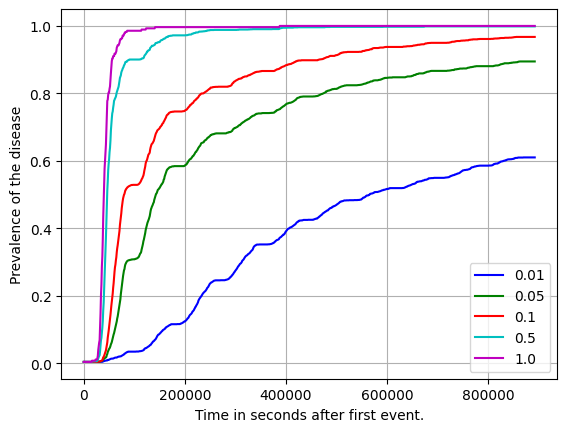

In [15]:
np.random.seed(96)  # please don't modify

n_it = 10  # number of iterations
infection_probs = [0.01, 0.05, 0.1, 0.5, 1.0]  # infection probabilities
id_seed = 27
n_time_steps = 1000

prevalence_data = []

time_steps = get_time_steps(event_file_path, n_time_steps)

# Calculate the prevalence for each infection probability
for prob in infection_probs:
    # Hints:
    # Repeate simulate_si n_it times for each probability. At each iteration, calculate the prevalence. After completing the iterations,
    # average the prevalence over iterations.
    prevalence_10 = np.zeros([n_it, len(time_steps)])
    for i in range(n_it):
        infection_times, _ = simulate_si(prob, event_file_path, airport_info_file_path, id_seed)
        # For calculating the prevalence, divide the whole time span (from the first departure time to the last arrival) into
        # equal-sized steps using the get_time_steps function you implemented above. You want to use same time steps for
        # all infection probabilities (these will define the x axis of the visualization).
        # For the prevalence calculations, use calculate_prevalence defined above. This function will be used also in all later
        # tasks, so don't worry about taking some time to implement it carefully.
        prevalence_10[i] = calculate_prevalence(infection_times, time_steps)
    prevalence_data.append(prevalence_10.mean(axis=0))

# For the next step (visualization), you need an np.array (or a list of lists) called prevalence_data
# that contains the prevalence as a function of time for each infection probability.
# Each row of this array corresponds to an infection probability, and the number of columns should equal to
# n_time_steps.
prevalence_data = np.array(prevalence_data)

colors = ['b', 'g', 'r', 'c', 'm']
labels = [str(p) for p in infection_probs]
plot_prevalence(prevalence_data, time_steps, colors, labels)
plt.show()  # This line prevents Jupyter notebook from showing the plot twice; please don't remove it

## Task 3: Effect of seed node selection on spreading speed

Next, we will investigate how the selection of the initially infected seed node affects the spreading
speed. To this end, use nodes with node-ids [5, 38, 74, 134, 143] (DTW, SMF, VPS, SYR, ILM) as seeds
and p = 0.1, and run the simulation 10 times for each seed node. Then, plot the average
prevalence of the disease separately for each seed node as a function of time (recycling
your code for Task 2).

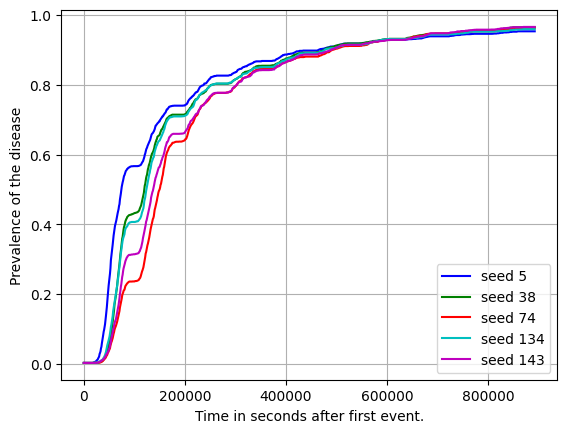

In [16]:
np.random.seed(12)  # please don't modify

n_it = 10
p = 0.1
seed_nodes = [5, 38, 74, 134, 143]
n_time_steps = 1000

prevalence_data = []

time_steps = get_time_steps(event_file_path, n_time_steps)

#Hints:

# You can re-use your code from task 2; just loop over seed nodes instead of infection probabilities.

# For the next step (visualization), you need a list (or np.array) called prevalence_data
# that contains the prevalence as a function of time (either list or np.array) for each seed node.
# Each row of this array corresponds to a seed node, and the number of columns should equal to
# n_time_steps.

for seed in seed_nodes:
    prevalence_10 = np.zeros([n_it, len(time_steps)])
    for i in range(n_it):
        infection_times, _ = simulate_si(p, event_file_path, airport_info_file_path, seed)
        prevalence_10[i] = calculate_prevalence(infection_times, time_steps)
    prevalence_data.append(prevalence_10.mean(axis=0))

prevalence_data = np.array(prevalence_data)

colors = ['b', 'g', 'r', 'c', 'm']
labels = ['seed ' + str(seed) for seed in seed_nodes]
plot_prevalence(prevalence_data, time_steps, colors, labels)
plt.show()  # This line prevents Jupyter notebook from showing the plot twice; please don't remove it

## Task 4: Where to hide?

Now, consider that you’d like to be as safe from the epidemic as possible. How should you select
your refuge? To answer this question, run your SI model 50 times with _p_ = 0.5 using different
random nodes as seeds and record the median infection times for each node. Create scatter plots showing the median infection time of each node as a function of the following nodal network measures:

1. unweighted clustering coefficient _c_
2. degree _k_
3. strength _s_
4. unweighted betweenness centrality

Then, use the Spearman rank-correlation coefficient for finding out which of the measures is the best predictor for the infection times.

In this task, you can use the pre-built static network (`aggregated_US_air_traffic_network_undir.edg`)
to compute the various centrality measures using the ready-made NetworkX functions. Function `dic_to_vec` is given to make it easier to handle the network properties.

In [17]:
def dict_to_vec(d):
    """
    Returns the values of a dictionary (e.g. a dictionary of network properties 
    returned by some networkX function) or a networkX DegreeView object
    as a list sorted in the order of dictionary keys (sorted with the sorted function). 
    Note that the order returned is not necessarily numerical; however, it is always the
    same for the same set of keys.
    
    Parameters:
    -----------
    d : dictionary or networkX DegreeView object
    
    Returns:
    --------
    vec : list
        list of d.values() sorted by d.keys()
    """
    vec = []
    if isinstance(d, dict):
        for key in sorted(d.keys()):
            vec.append(d[key])
    elif isinstance(d, nx.classes.reportviews.DegreeView) or isinstance(d, nx.classes.reportviews.DiDegreeView):
        nodes = sorted([d1[0] for d1 in d])
        for node in nodes:
            vec.append(d[node])
    return vec

In [18]:
np.random.seed(25)  # please don't modify

p = 0.5
n_seeds = 50

net, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

inf_time_data = []

median_inf_times = []
props = []

# Run simulate_si for 50 random seeds to obtain the median infection time; obtain the listed
# network properties
# e.g. [0, 1, ..., 278]
airports_idxs = pd.read_csv(airport_info_file_path).index
random_seeds = np.random.choice(airports_idxs, size=n_seeds, replace=False)


infections_50 = np.zeros([n_seeds, len(airports_idxs)])
for idx, id_seed in enumerate(random_seeds):
    infection_times, _ = simulate_si(p, event_file_path, airport_info_file_path, id_seed)
    infections_50[idx] = infection_times

In [42]:
# infections_50[infections_50 == np.inf] = np.max(infections_50[infections_50 != np.inf])
infections_50[infections_50 == np.inf] = infections_50.max()
median_inf_times = np.median(infections_50, axis=0)

# Hints:
# If a node gets infected in less than half of the iterations, its median infection time is Inf. Before visualization and
# calculating the correlations, you need to replace these values with some large number, e.g. the largest observed non-Inf
# median infection time.
# median_inf_times

In [21]:
c = dict_to_vec(nx.clustering(net))
k = dict_to_vec(nx.degree(net))
s = dict_to_vec(nx.degree(net, weight="weight"))
bc = dict_to_vec(nx.betweenness_centrality(net))

-0.1328135933718801
Spearman r betweebetween median infection time andn median infection time and c: -0.1328135933718801
-0.8115372212579356
Spearman r betweebetween median infection time andn median infection time and k: -0.8115372212579356
-0.87616578100491
Spearman r betweebetween median infection time andn median infection time and s: -0.87616578100491
-0.6182530687304854
Spearman r betweebetween median infection time andn median infection time and bc: -0.6182530687304854


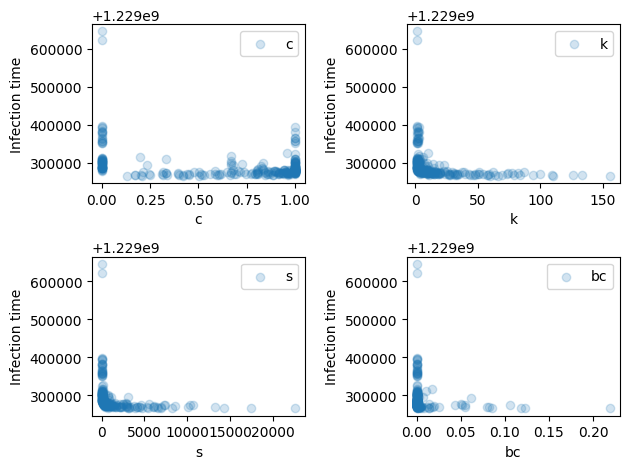

In [22]:
# For the next step (visualization), you need a list (or n.array) of median infection times
# (median_infection_times) and a nested list (called props) where each element is a list containing
# the values of one network property for all nodes. All the lists in props need to be in the same
# order.
prop_names = ["c", "k", "s", "bc"]

props = [c, k, s, bc]

plot_scatters_in_subplots(props, median_inf_times, labels=prop_names)

rs = [c, k, s, bc]

# Calculate the Spearman rank correlation between each network property and median infection times
# Hint: scipy.stats.spearmanr
for prop_name, r in zip(prop_names, rs):
    r = scipy.stats.spearmanr(r, median_inf_times).correlation
    print('Spearman r betweebetween median infection time andn median infection time and {property}: {r!s}'.format(property=prop_name, r=r))

## Task 5: Shutting down airports

Now take the role of a government official considering shutting down airports to prevent the
disease from spreading to the whole country. In our simulations, shutting down airports
corresponds to immunization: an airport that has been shut down can not become infected at
any point of the simulation and thus cannot transmit the disease.

One immunization strategy suggested for use in social networks is to pick a random node and immunize a random neighbour of this node. Your task is now to compare
this strategy against five other immunization strategies: the immunization of random nodes
and the immunization of with the largest values of the four node properties calculated in task 4. 

Using each of the immunization strategies, immunize 10 nodes. Then, plot the average prevalence as a function of time for each immunization strategy. Use _p_ = 0.5 and average the prevalence over 20 runs of the model for each immunization strategy, each with a different seed node (120 simulations in total). 

To reduce the variance due to the selection of seed nodes, use same seed nodes for investigating
all immunization strategies. To this end, first select your immunized nodes, and then select 20
random seed nodes such that none of them belongs to the group of immunized nodes in any of
the 6 different strategies.

Note that depending on your implementation of `simulate_si`, running this task may take some time (up to around 5 min). If the running time is particularly long, you may want to first use a lower value of `n_seeds` and set it to 50 only when you're sure that your code works as it should.

In [38]:
np.random.seed(81)  # please don't modify

p = 0.5
n_seeds = 20
n_immunized = 10
n_time_steps = 1000

strategy_names = ["c", "k", "s", "bc", "random", "soc. net. im."]

net, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

prevalence_data = []

time_steps = get_time_steps(event_file_path, n_time_steps)

# Calculate the prevalence for each immunization strategy
# Hints:

# Modify your implementation of simulate_si from task 1 to allow node immunization. To this end, add a list 
# (or set) of immunized nodes as an optional input, with an empty list (or set) as the default value. Then, 
# when about to infect a node, check if the node is in the list/set, and if, do not infect.

# Before running simulate_si, define the immunized nodes for each of the 6 strategies and the seed nodes. You want
# to use the same random seed nodes for each immunization strategy. While selecting the seeds, ensure that they
# are not among the immunized nodes.

# You can re-use your code from task 2, this time looping over immunization strategies.

# For the next step (visualization), you need a list (or np.array) called prevalence_data
# that contains the prevalence as a function of time (either list or np.array).
# Each row of this array corresponds to an immunization strategy, and the number of columns should equal to
# n_time_steps.


def order_dict_by_val(d):
    # {'a': 3, 'b': 1, 'c': 2}
    # {'a': 1, 'c': 2, 'b': 3}
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
def get_best_dict_values(d):
    # DegreeView to dict
    if isinstance(d, nx.classes.reportviews.DegreeView) or isinstance(d, nx.classes.reportviews.DiDegreeView):
        d = {k: v for k, v in d}
    d = order_dict_by_val(d)
    # Take n_immunized keys with highest values
    return list(d.keys())[-n_immunized:]

c = get_best_dict_values(nx.clustering(net))
k = get_best_dict_values(nx.degree(net))
s = get_best_dict_values(nx.degree(net, weight="weight"))
bc = get_best_dict_values(nx.betweenness_centrality(net))
rand = list(np.random.choice(list(net.nodes()), size=n_immunized))
rand_soc = np.random.choice(list(net.nodes()), size=n_immunized)
# Get one neighbor for each node
soc_net_im = [np.random.choice(list(net.neighbors(node))) for node in rand_soc]

# strategy_names = ["c", "k", "s", "bc", "random", "soc. net. im."]
all_susceptible_nodes = set(net.nodes()) - set([*c, *k, *s, *bc, *rand, *soc_net_im])
random_susceptible_nodes = np.random.choice(list(all_susceptible_nodes), size=n_seeds)

In [26]:
for immunizated_nodes in tqdm([c, k, s, bc, rand, soc_net_im]):
    prevalence = 0
    for seed in random_susceptible_nodes:
        infection_times, _ = simulate_si(p, event_file_path, airport_info_file_path, seed, immunizated_nodes)
        prevalence += calculate_prevalence(infection_times, time_steps)
    prevalence_data.append(prevalence / n_seeds)


100%|██████████| 6/6 [01:17<00:00, 12.94s/it]


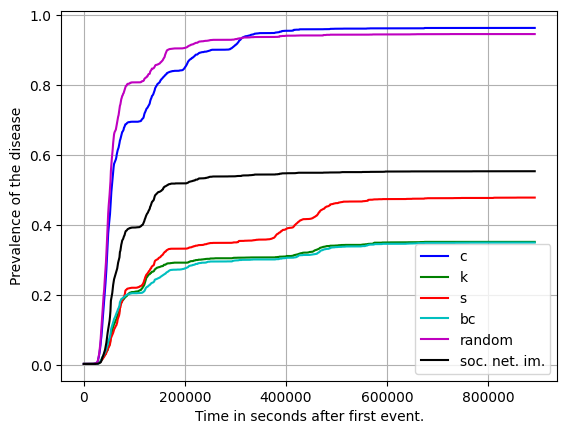

In [27]:
prevalence = np.array(prevalence_data)

colors = ['b', 'g', 'r', 'c', 'm', 'k']
plot_prevalence(prevalence_data, time_steps, colors, labels=strategy_names)

plt.show()  # This line prevents Jupyter notebook from showing the plot twice; please don't remove it

## Task 6: Disease-transmitting links

So far we have only analyzed the importance of network nodes — next, we will discuss the role of
links. We will do this by recording the number of times each link transmits the disease from one node to
another. 

So, adapt your code for recording the static links which are used to
transmit the disease. You can do this e.g. by storing for each node where the infection came from. For example, if node _i_ gets infected by a flight arriving from node _j_, you should store the information of _i_ being infected by _j_. This can be done by using a list `trans_nodes`, where `trans_nodes[i] = j`.

Run 20 simulations using random nodes as seeds and _p_ = 0.5. For each simulation, record which links are used to
infect the yet uninfected airports (either by first infection-carrying flights arriving to susceptible airports or by infecting flights arriving before the already recorded infection time). After running the simulations, compute the fraction of simulations where each link transmitted the disease ($f_{ij}$). For example, if the disease spread from node _a_ to node _b_ in 5 simulations out of 20, $f_{ab}$ = 0.2.

Then, use the function `plot_network_USA which` provided above to visualize the network on top of the US map. Adjust the width of the links according to the fractions $f_{ij}$ to better see the overall structure. Compare your visualization with the maximal spanning tree of the network.

Then, create scatter plots showing $f_{ij}$ as a function of the following link properties:

1. link weight $w_{ij}$
2. unweighted link betweenness centrality $eb_{ij}$ (`edge_betweenness_centrality` in NetworkX)

Compute also the Spearman correlation coefficients between $f_{ij}$ and the two link-wise
measures.

In [40]:
np.random.seed(22)  # please don't modify

p = 0.5
n_seeds = 20

net, id_data = get_net_and_id_data(network_file_path, airport_info_file_path)

# Calculate the fraction of simulations each link carried the disease and construct the maximal spanning
# tree of the network.

# Hints:
# Modify your implementation of simulate_si from task 1 to record which links carried the disease.

# For running the simulations, you can again re-use your code from task 2.

# When calculating the link transmission fractions, note that a link may have carried the disease in different directions
# (i -> j and j -> i) in different simulations. Since the transmission fraction is undirected, both directions count:
# f_ij = f_ji = (n_ij + n_ji) / n_simulations

# Feel free to use the networkX function for calculating the maximum spanning tree.

# For the next step (visualization), you need a list of links of the network (called links), a list of disease
# transmission fractions per link (called link_trans_fracs; this should be in the same order as links), and the maximum spanning 
# tree (called mst).

links = list(net.edges())
link_trans_fracs = np.zeros(net.number_of_edges())

for i in tqdm(range(n_seeds)):
    prevalence = 0
    for seed in random_susceptible_nodes:
        _, _, trans_nodes = simulate_si(p, event_file_path, airport_info_file_path, seed, return_trans_nodes=True)

    for (idx, (i, j)) in enumerate(links):
        if trans_nodes[i] == j or trans_nodes[j] == i:
            link_trans_fracs[idx] += 1

link_trans_fracs /= n_seeds
mst = nx.maximum_spanning_tree(net)

100%|██████████| 20/20 [04:16<00:00, 12.83s/it]


Spearman r between link transmission fraction and weight: 0.23423712295685867
Spearman r between link transmission fraction and edge betweenness: 0.39483469257913095


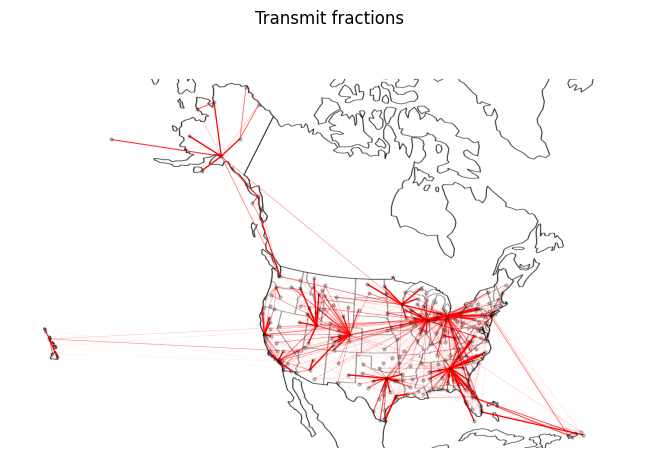

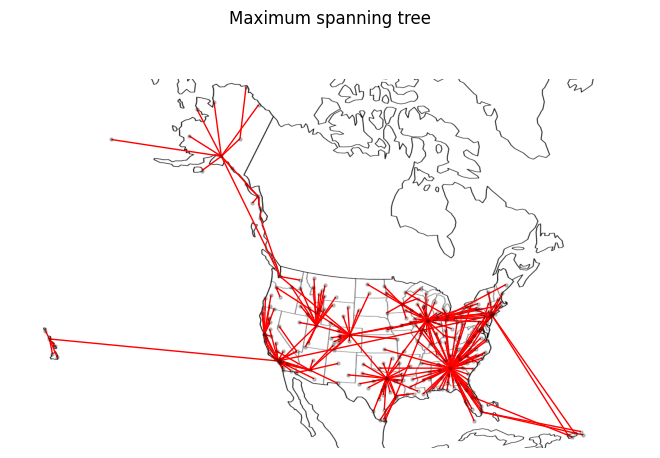

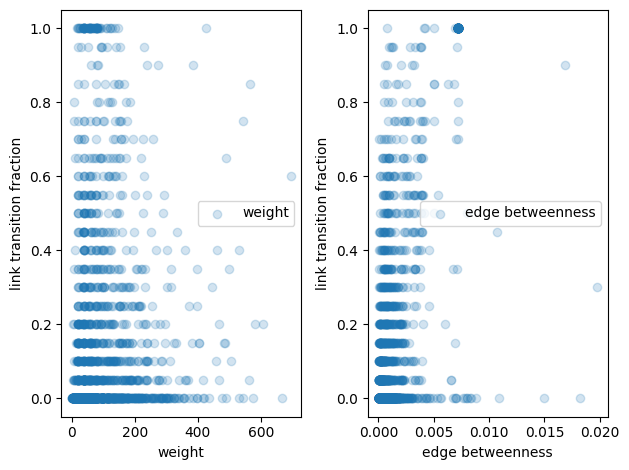

In [41]:
# coordinates of nodes are needed for visualization
id_data = np.genfromtxt(airport_info_file_path, delimiter=',', dtype=None, names=True, encoding=None)
xycoords = {}
for row in id_data:
    xycoords[int(row['id'])] = (row['xcoordviz'], row['ycoordviz'])

fig, ax = plot_network_usa(net, xycoords, background_image_file_path, edges=links, linewidths=link_trans_fracs)
fig.suptitle('Transmit fractions')

fig, ax = plot_network_usa(net, xycoords, background_image_file_path, edges=mst.edges())
fig.suptitle('Maximum spanning tree')

# Obtain the weight and edge betweenness of each link.
# Hints:

# Make use of nx.edge_betweenness_centrality.

# For the next step (visualization), you need lists or np.arrays of link weights (called weights) and
# edge betweenness centralities (called ebs).


weights = [net[link[0]][link[1]]['weight'] for link in links]
edge_bc = nx.edge_betweenness_centrality(net)
ebs = [edge_bc[link] for link in links]







props = [weights, ebs]
prop_names = ['weight', 'edge betweenness']

plot_scatters_in_subplots(props, link_trans_fracs, labels=prop_names, n_columns=2, y_label='link transition fraction', x_labels=[])

rs = []

# Calculate the Spearman rank correlation between the link-wise properties and link transition fraction.


for prop in props:
    rs.append(scipy.stats.spearmanr(prop, link_trans_fracs).correlation)



for prop_name, r in zip(prop_names, rs):
    print('Spearman r between link transmission fraction and {prop}: {r!s}'.format(prop=prop_name, r=r))